In [451]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp

from keras import callbacks
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
import keras.backend as K
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
%config IPCompleter.greedy=True

# Data Preprocessing

In [524]:
train_dataset = pd.read_csv("GMR_Samples_Mass/All_JENDL_GMR.csv")
#train_dataset = train_dataset.iloc[: , 1:]


train_dataset = train_dataset[(train_dataset['Z'] != 92) | (train_dataset['N'] != 143) ] #| (train_dataset['E'] == 20.5455)] #U-235

mask = (train_dataset.iloc[:, 0] >= 0) & (train_dataset.iloc[:, 1] >= 0)
train_dataset = train_dataset[mask]

X_train = train_dataset.loc[:, train_dataset.columns != 'Fission Yield']
y_train = train_dataset['Fission Yield']

# -------------------------- Πυρήνας που θέλουμε να προβλέψουμε----------------------------
Z = 92
N = 143
E = 20.5455

#-------------------------- Incomplete fission yields----------------------------------
Pred_Dat7 = pd.read_csv("Incomp_U235_1,37.csv")
Pred_Dat8 = pd.read_csv("Incomp_U235_4,49.csv")
Pred_Dat9 = pd.read_csv("Incomp_U235_8,9.csv")
Pred_Dat10 = pd.read_csv("Incomp_U235_14,8.csv")
X_Pred_Dat7 = Pred_Dat7["A"]
y_Pred_Dat7 = Pred_Dat7["FY"]                                       
y_error7 = Pred_Dat7["ERROR"]
X_Pred_Dat8 = Pred_Dat8["A"]
y_Pred_Dat8 = Pred_Dat8["FY"]                                       
y_error8 = Pred_Dat8["ERROR"]
X_Pred_Dat9 = Pred_Dat9["A"]
y_Pred_Dat9 = Pred_Dat9["FY"]                                       
y_error9 = Pred_Dat9["ERROR"]
X_Pred_Dat10 = Pred_Dat10["A"]
y_Pred_Dat10 = Pred_Dat10["FY"]                                       
y_error10 = Pred_Dat10["ERROR"]
#--------------------------------------------------------------------------------------'''

# ---------------------------- Πειραματικά δεδομένα απλά για το scatterplot -----------
Pred_Dat = pd.read_csv("../test1/All_JENDL.csv")
Pred_Dat1 = Pred_Dat[(Pred_Dat['Z'] == 90) & (Pred_Dat['N'] ==142 ) & (Pred_Dat['E'] == 5.28639)] #Th-232
Pred_Dat2 = Pred_Dat[(Pred_Dat['Z'] == 92) & (Pred_Dat['N'] == 146) & (Pred_Dat['E'] == 18.80638)] #U-238
Pred_Dat3 = Pred_Dat[(Pred_Dat['Z'] == 94) & (Pred_Dat['N'] == 146) & (Pred_Dat['E'] == 5.74152)]  #Pu-240
Pred_Dat4 = Pred_Dat[(Pred_Dat['Z'] == 94) & (Pred_Dat['N'] == 146) & (Pred_Dat['E'] == 19.24152)] #Pu-240
Pred_Dat5 = Pred_Dat[(Pred_Dat['Z'] == 96) & (Pred_Dat['N'] == 147) & (Pred_Dat['E'] == 7.301399999999999)] #Cm-243
Pred_Dat6 = Pred_Dat[(Pred_Dat['Z'] == 98) & (Pred_Dat['N'] == 151) & (Pred_Dat['E'] == 6.6237000253)] #Cf-249
Pred_Dat11 = Pred_Dat[(Pred_Dat['Z'] == 92) & (Pred_Dat['N'] == 143) & (Pred_Dat['E'] == 6.5455000253)] 
Pred_Dat12 = Pred_Dat[(Pred_Dat['Z'] == 92) & (Pred_Dat['N'] == 143) & (Pred_Dat['E'] == 7.0455)] 
Pred_Dat13 = Pred_Dat[(Pred_Dat['Z'] == 92) & (Pred_Dat['N'] == 143) & (Pred_Dat['E'] == 20.5455)]

X_Pred_Dat1 = Pred_Dat1.loc[:, Pred_Dat1.columns != 'Fission Yield']
X_Pred_Dat2 = Pred_Dat2.loc[:, Pred_Dat2.columns != 'Fission Yield']
X_Pred_Dat3 = Pred_Dat3.loc[:, Pred_Dat3.columns != 'Fission Yield']
X_Pred_Dat4 = Pred_Dat4.loc[:, Pred_Dat4.columns != 'Fission Yield']
X_Pred_Dat5 = Pred_Dat5.loc[:, Pred_Dat5.columns != 'Fission Yield']
X_Pred_Dat6 = Pred_Dat6.loc[:, Pred_Dat6.columns != 'Fission Yield']
X_Pred_Dat11 = Pred_Dat11.loc[:, Pred_Dat11.columns != 'Fission Yield']
X_Pred_Dat12 = Pred_Dat12.loc[:, Pred_Dat12.columns != 'Fission Yield']
X_Pred_Dat13 = Pred_Dat13.loc[:, Pred_Dat13.columns != 'Fission Yield']
y_Pred_Dat1 = Pred_Dat1.loc[:, Pred_Dat1.columns == 'Fission Yield']
y_Pred_Dat2 = Pred_Dat2.loc[:, Pred_Dat2.columns == 'Fission Yield']
y_Pred_Dat3 = Pred_Dat3.loc[:, Pred_Dat3.columns == 'Fission Yield']
y_Pred_Dat4 = Pred_Dat4.loc[:, Pred_Dat4.columns == 'Fission Yield']
y_Pred_Dat5 = Pred_Dat5.loc[:, Pred_Dat5.columns == 'Fission Yield']
y_Pred_Dat6 = Pred_Dat6.loc[:, Pred_Dat6.columns == 'Fission Yield']
y_Pred_Dat11 = Pred_Dat11.loc[:, Pred_Dat11.columns == 'Fission Yield']
y_Pred_Dat12 = Pred_Dat12.loc[:, Pred_Dat12.columns == 'Fission Yield']
y_Pred_Dat13 = Pred_Dat13.loc[:, Pred_Dat13.columns == 'Fission Yield']
y_Pred_Dat14 = Pred_Dat12.loc[:, Pred_Dat12.columns == 'Fission Yield']
y_Pred_Dat15 = Pred_Dat5.loc[:, Pred_Dat5.columns == 'Fission Yield']
X_Pred_Dat1 = X_Pred_Dat1.to_numpy()
X_Pred_Dat2 = X_Pred_Dat2.to_numpy()
X_Pred_Dat3 = X_Pred_Dat3.to_numpy()
X_Pred_Dat4 = X_Pred_Dat4.to_numpy()
X_Pred_Dat5 = X_Pred_Dat5.to_numpy()
X_Pred_Dat6 = X_Pred_Dat6.to_numpy()
X_Pred_Dat7 = X_Pred_Dat7.to_numpy()
X_Pred_Dat8 = X_Pred_Dat8.to_numpy()
X_Pred_Dat9 = X_Pred_Dat9.to_numpy()
X_Pred_Dat10 = X_Pred_Dat10.to_numpy()
X_Pred_Dat11 = X_Pred_Dat11.to_numpy()
X_Pred_Dat12 = X_Pred_Dat12.to_numpy()
X_Pred_Dat13 = X_Pred_Dat13.to_numpy()
y_Pred_Dat1 = y_Pred_Dat1.to_numpy()
y_Pred_Dat2 = y_Pred_Dat2.to_numpy()
y_Pred_Dat3 = y_Pred_Dat3.to_numpy()
y_Pred_Dat4 = y_Pred_Dat4.to_numpy()
y_Pred_Dat5 = y_Pred_Dat5.to_numpy()
y_Pred_Dat6 = y_Pred_Dat6.to_numpy()
y_Pred_Dat7 = y_Pred_Dat7.to_numpy()
y_Pred_Dat8 = y_Pred_Dat8.to_numpy()
y_Pred_Dat9 = y_Pred_Dat9.to_numpy()
y_Pred_Dat10 = y_Pred_Dat10.to_numpy()
y_Pred_Dat11 = y_Pred_Dat11.to_numpy()
y_Pred_Dat12 = y_Pred_Dat12.to_numpy()
y_Pred_Dat13 = y_Pred_Dat13.to_numpy()
y_Pred_Dat14 = y_Pred_Dat14.to_numpy()
y_Pred_Dat15 = y_Pred_Dat15.to_numpy()
# -------------------------------------------------------------------------------------

# ----------------------------- Samples  για πρόβλεψη ---------------------------------
Pred_Dat_Enh = pd.read_csv("GMR_Samples_Mass/All_JENDL_GMR.csv")
Pred_Dat_Enh_Inc1 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] ==92 ) & (Pred_Dat_Enh['N'] ==143 ) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh_Inc2 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] ==92 ) & (Pred_Dat_Enh['N'] ==143 ) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh1 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 90) & (Pred_Dat_Enh['N'] == 142) & (Pred_Dat_Enh['E'] == 5.28639)]
Pred_Dat_Enh2 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 146) & (Pred_Dat_Enh['E'] == 18.80638)]
Pred_Dat_Enh3 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 94) & (Pred_Dat_Enh['N'] == 146) & (Pred_Dat_Enh['E'] == 5.74152)]
Pred_Dat_Enh4 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 94) & (Pred_Dat_Enh['N'] == 146) & (Pred_Dat_Enh['E'] == 19.24152)]
Pred_Dat_Enh5 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 96) & (Pred_Dat_Enh['N'] == 147) & (Pred_Dat_Enh['E'] == 7.301399999999999)]
Pred_Dat_Enh6 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 98) & (Pred_Dat_Enh['N'] == 151) & (Pred_Dat_Enh['E'] == 6.6237000253)]
Pred_Dat_Enh7 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh8 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh9 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh10 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 7.0455)]
Pred_Dat_Enh11 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 6.5455000253)] 
Pred_Dat_Enh12 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 7.0455)] 
Pred_Dat_Enh13 = Pred_Dat_Enh[(Pred_Dat_Enh['Z'] == 92) & (Pred_Dat_Enh['N'] == 143) & (Pred_Dat_Enh['E'] == 20.5455)]

#Pred_Dat_Enh['Ac'] = Pred_Dat_Enh['N'] + Pred_Dat_Enh['Z']
print("Pred_Dat_Enh: \n",Pred_Dat_Enh[0:5])

X_Pred_Dat_Enh1 = Pred_Dat_Enh1.loc[:, Pred_Dat_Enh1.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh2 = Pred_Dat_Enh2.loc[:, Pred_Dat_Enh2.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh3 = Pred_Dat_Enh3.loc[:, Pred_Dat_Enh3.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh4 = Pred_Dat_Enh4.loc[:, Pred_Dat_Enh4.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh5 = Pred_Dat_Enh5.loc[:, Pred_Dat_Enh5.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh6 = Pred_Dat_Enh6.loc[:, Pred_Dat_Enh6.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh7 = Pred_Dat_Enh7.loc[:, Pred_Dat_Enh7.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh8 = Pred_Dat_Enh8.loc[:, Pred_Dat_Enh8.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh9 = Pred_Dat_Enh9.loc[:, Pred_Dat_Enh9.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh10 = Pred_Dat_Enh10.loc[:, Pred_Dat_Enh10.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh11 = Pred_Dat_Enh11.loc[:, Pred_Dat_Enh11.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh12 = Pred_Dat_Enh12.loc[:, Pred_Dat_Enh12.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column
X_Pred_Dat_Enh13 = Pred_Dat_Enh13.loc[:, Pred_Dat_Enh13.columns != 'Fission Yield'] #Φίλτρο για να βγάλω το Fission Yield column

X_Pred_Dat_Enh7["E"] = 6.5455 + 1.37 #Πρόβλεψη για άλλη ενέργεια
X_Pred_Dat_Enh8["E"] = 6.5455 + 4.49 #Πρόβλεψη για άλλη ενέργεια
X_Pred_Dat_Enh9["E"] = 6.5455 + 8.9 #Πρόβλεψη για άλλη ενέργεια
X_Pred_Dat_Enh10["E"] = 6.5455 + 14.8 #Πρόβλεψη για άλλη ενέργεια
# -------------------------------------------------------------------------------------

print("X_Pred_Dat Debug: \n",X_Pred_Dat_Enh[0:5])

# -------------------------------- Test Dataset ---------------------------------------
test_dataset = pd.read_csv("../test1/All_JENDL.csv")
test_dataset = test_dataset[(test_dataset['Z'] != Z) | (test_dataset['N'] != N)]# | (test_dataset['E'] ==18.78639)]

X_test = test_dataset.loc[:, test_dataset.columns != 'Fission Yield']
X_test = X_test.to_numpy() # Αλλαγή dataset type από pandas_dataframe σε numpy_array

test_dataset = test_dataset.to_numpy()
y_test = test_dataset[:,1] #Fission yield (test dataset)


train_dataset = np.column_stack((X_train, y_train))
test_dataset = np.column_stack((X_test, y_test))
#y_test = y_test.reshape(-1,1)

#max_train_y = y_train.max()
#min_train_y = y_train.min()

#y_train = (y_train - min_train_y) / (max_train_y - min_train_y)
#y_test = (y_test - min_train_y) / (max_train_y - min_train_y)
#y_Pred_Dat = (y_Pred_Dat - min_train_y) / (max_train_y - min_train_y)
'''
print("\ntrain_dataset shape:  ",train_dataset.shape)
print("test_dataset shape:   ",test_dataset.shape)
print("Pred_Dat shape:       ",Pred_Dat.shape)
print("\nPred_Dat_Enh shape:    ",Pred_Dat_Enh.shape)
print("\nX_train shape:        ",X_train.shape)
print("X_test shape:         ",X_test.shape)
print("X_Pred_Dat shape:     ",X_Pred_Dat.shape)
print("X_Pred_Dat_Enh shape: ",X_Pred_Dat_Enh.shape)
print("\ny_train shape:        ",y_train.shape)'''

# ----------------------------- Normalization of inputs----------------
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#X_Pred_Dat = scaler.transform(X_Pred_Dat)
X_Pred_Dat_Enh1 = scaler.transform(X_Pred_Dat_Enh1)
X_Pred_Dat_Enh2 = scaler.transform(X_Pred_Dat_Enh2)
X_Pred_Dat_Enh3 = scaler.transform(X_Pred_Dat_Enh3)
X_Pred_Dat_Enh4 = scaler.transform(X_Pred_Dat_Enh4)
X_Pred_Dat_Enh5 = scaler.transform(X_Pred_Dat_Enh5)
X_Pred_Dat_Enh6 = scaler.transform(X_Pred_Dat_Enh6)
X_Pred_Dat_Enh7 = scaler.transform(X_Pred_Dat_Enh7)
X_Pred_Dat_Enh8 = scaler.transform(X_Pred_Dat_Enh8)
X_Pred_Dat_Enh9 = scaler.transform(X_Pred_Dat_Enh9)
X_Pred_Dat_Enh10 = scaler.transform(X_Pred_Dat_Enh10)
X_Pred_Dat_Enh11 = scaler.transform(X_Pred_Dat_Enh11)
X_Pred_Dat_Enh12 = scaler.transform(X_Pred_Dat_Enh12)
X_Pred_Dat_Enh13 = scaler.transform(X_Pred_Dat_Enh13)
X_Pred_Dat14 = scaler.transform(X_Pred_Dat12)
X_Pred_Dat15 = scaler.transform(X_Pred_Dat5)

# --------------------------------------------------------------------

#X_train = X_train.to_numpy()
X_train = np.asarray(X_train)
#X_test = np.asarray(X_test)
#X_Pred_Dat = np.asarray(X_Pred_Dat)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1) 
#y_test = np.asarray(y_test)
#Pred_Dat = Pred_Dat.to_numpy()
#X_Pred_Dat = X_Pred_Dat.to_numpy()
#X_Pred_Dat_Enh = X_Pred_Dat_Enh.to_numpy()

print("\nX_Pred_Dat Debug Normalized: \n",X_Pred_Dat[0:5])

print("\nDataset shapes:")
print("\ntrain_dataset shape:  ",train_dataset.shape)
print("test_dataset shape:   ",test_dataset.shape)
print("Pred_Dat shape:       ",Pred_Dat.shape)
print("\nPred_Dat_Enh shape:    ",Pred_Dat_Enh.shape)
print("\nX_train shape:        ",X_train.shape)
print("X_test shape:         ",X_test.shape)
print("X_Pred_Dat shape:     ",X_Pred_Dat.shape)
print("X_Pred_Dat_Enh shape: ",X_Pred_Dat_Enh.shape)
print("\ny_train shape:        ",y_train.shape)
print("y_test shape:         ",y_test.shape)
print("y_Pred_Dat shape:     ",y_Pred_Dat.shape)

Pred_Dat_Enh: 
            A  Fission Yield   Z       E    N
0  66.000000      -0.000056  90  7.1052  137
1  66.010601      -0.000056  90  7.1052  137
2  66.021202      -0.000056  90  7.1052  137
3  66.031803      -0.000055  90  7.1052  137
4  66.042404      -0.000055  90  7.1052  137
X_Pred_Dat Debug: 
 [[1986.30327128  303.71258043  123.32515293  690.21570602]
 [1986.60322336  303.71258043  123.32515293  690.21570602]
 [1986.90317544  303.71258043  123.32515293  690.21570602]
 [1987.20312753  303.71258043  123.32515293  690.21570602]
 [1987.50307961  303.71258043  123.32515293  690.21570602]]

X_Pred_Dat Debug Normalized: 
 [[ 66.      92.      20.5455 143.    ]
 [ 67.      92.      20.5455 143.    ]
 [ 68.      92.      20.5455 143.    ]
 [ 69.      92.      20.5455 143.    ]
 [ 70.      92.      20.5455 143.    ]]

Dataset shapes:

train_dataset shape:   (402526, 5)
test_dataset shape:    (5025, 5)
Pred_Dat shape:        (5346, 5)

Pred_Dat_Enh shape:     (500000, 5)

X_train shape

/tmp/ipykernel_103006/3534356846.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Pred_Dat_Enh7["E"] = 6.5455 + 1.37 #Πρόβλεψη για άλλη ενέργεια
/tmp/ipykernel_103006/3534356846.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Pred_Dat_Enh8["E"] = 6.5455 + 4.49 #Πρόβλεψη για άλλη ενέργεια
/tmp/ipykernel_103006/3534356846.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# Model Development

In [525]:
# Δεν αλλάζει το class του MDN είναι fixed!

class MixtureDensityOutput(tf.keras.layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = tf.keras.layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        )  # mix*output vals, no activation
        self.mdn_sigmas = tf.keras.layers.Dense(
            self.num_mix * self.output_dim,
            activation='softmax',
            name="mdn_sigmas",
        )  # mix*output vals exp activation
        self.mdn_pi = tf.keras.layers.Dense(self.num_mix, name="mdn_pi")  # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    def call(self, x, mask=None):
        return tf.keras.layers.concatenate(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], name="mdn_outputs"
        )

    def get_config(self):
        config = super().get_config()
        config.update({
            'output_dimension': self.output_dim,
            'num_mixtures': self.num_mix
        })
        return config


In [526]:
OUTPUT_DIMS = 1
N_MIXES = 3 #Number of gaussians
N_HIDDEN = 100 # neurons/layer

mdn_network = tf.keras.Sequential(
    [
    #tf.keras.layers.Dense(N_HIDDEN-10, activation="sigmoid"),
    #tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="relu"),
    tf.keras.layers.Dense(N_HIDDEN, activation="tanh"),
    MixtureDensityOutput(OUTPUT_DIMS, N_MIXES)
])



In [527]:
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(
            y_pred,
            [-1, (2 * num_mixes * output_dim) + num_mixes],
            name="reshape_ypreds",
        )
        y_true = tf.reshape(y_true, [-1, output_dim], name="reshape_ytrue")
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            num_or_size_splits=[
                num_mixes * output_dim,
                num_mixes * output_dim,
                num_mixes,
            ],
            axis=-1,
            name="mdn_coef_split",
        )
        # Construct the mixture models
        cat = tfp.distributions.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [
            tfp.distributions.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfp.distributions.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    return mdn_loss_func

mdn_network.compile(loss=get_mixture_loss_func(OUTPUT_DIMS, N_MIXES), optimizer=tf.keras.optimizers.Adam())

# Fit

In [528]:
history = mdn_network.fit(
    X_train,
    y_train,
    epochs=1100,
    batch_size=2000,
    validation_data=(X_test,y_test),
    callbacks=[
    callbacks.EarlyStopping(monitor="val_loss", patience=700, restore_best_weights=True, min_delta=-0.001),
    ReduceLROnPlateau(monitor='val_loss', patience=100)
    #callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, min_delta=-0.001)
    ]
)
#mdn_network.save_weights('Am-241_14')

mdn_network.summary()

Epoch 1/1100
202/202 [==============================] - 48s 82ms/step - loss: -1.1960 - val_loss: -1.1901 - lr: 0.0010
Epoch 2/1100
202/202 [==============================] - 4s 20ms/step - loss: -1.8678 - val_loss: -1.6396 - lr: 0.0010
Epoch 3/1100
202/202 [==============================] - 2s 11ms/step - loss: -2.0483 - val_loss: -2.7922 - lr: 0.0010
Epoch 4/1100
202/202 [==============================] - 2s 10ms/step - loss: -1.9135 - val_loss: -1.7492 - lr: 0.0010
Epoch 5/1100
202/202 [==============================] - 2s 11ms/step - loss: -1.7043 - val_loss: -2.2489 - lr: 0.0010
Epoch 6/1100
202/202 [==============================] - 2s 9ms/step - loss: -2.1570 - val_loss: -1.6146 - lr: 0.0010
Epoch 7/1100
202/202 [==============================] - 2s 9ms/step - loss: -2.0042 - val_loss: -1.6691 - lr: 0.0010
Epoch 8/1100
202/202 [==============================] - 2s 8ms/step - loss: -2.2265 - val_loss: 0.0163 - lr: 0.0010
Epoch 9/1100
202/202 [==============================] - 2s 

    callbacks=[
        callbacks.EarlyStopping(monitor="val_loss", patience=70, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=5)]
)

# Model Prediction and Graph

In [529]:
# ------------------------- Predicted yield -----------------
y_pred_mixture1 = mdn_network.predict(X_Pred_Dat_Enh1)
y_pred_mixture2 = mdn_network.predict(X_Pred_Dat_Enh2)
y_pred_mixture3 = mdn_network.predict(X_Pred_Dat_Enh3)
y_pred_mixture4 = mdn_network.predict(X_Pred_Dat_Enh4)
y_pred_mixture5 = mdn_network.predict(X_Pred_Dat_Enh5)

'''
#y_pred_mixture2 = mdn_network.predict(X_Pred_Dat_Enh2)
#y_pred_mixture3 = mdn_network.predict(X_Pred_Dat_Enh3)
#y_pred_mixture4 = mdn_network.predict(X_Pred_Dat_Enh4)
#print("y_pred_mixture shape: ",y_pred_mixture.shape)
'''
# ----------------------------------------------------------

# -----------------------------Denormalize τα inputs -----
X_train = scaler.inverse_transform(X_train)

# Denormalize X_test
#X_test = scaler.inverse_transform(X_test)

# Denormalize X_Pred_Dat
#X_Pred_Dat = scaler.inverse_transform(X_Pred_Dat)
#X_Pred_Dat2 = scaler.inverse_transform(X_Pred_Dat2)

# Denormalize X_Pred_Dat_Enh
X_Pred_Dat_Enh1 = scaler.inverse_transform(X_Pred_Dat_Enh1)
X_Pred_Dat_Enh2 = scaler.inverse_transform(X_Pred_Dat_Enh2)
X_Pred_Dat_Enh3 = scaler.inverse_transform(X_Pred_Dat_Enh3)
X_Pred_Dat_Enh4 = scaler.inverse_transform(X_Pred_Dat_Enh4)
X_Pred_Dat_Enh5 = scaler.inverse_transform(X_Pred_Dat_Enh5)

#X_Pred_Dat_Enh2 = scaler.inverse_transform(X_Pred_Dat_Enh2)
#X_Pred_Dat_Enh3 = scaler.inverse_transform(X_Pred_Dat_Enh3)
#X_Pred_Dat_Enh4 = scaler.inverse_transform(X_Pred_Dat_Enh4)

# ----------------------------------------------------------
print(X_Pred_Dat_Enh.shape)

313/313 [==============================] - 0s 700us/step
(10000, 4)


In [530]:
y_pred_mixture6 = mdn_network.predict(X_Pred_Dat_Enh6)
y_pred_mixture7 = mdn_network.predict(X_Pred_Dat_Enh7)
y_pred_mixture8 = mdn_network.predict(X_Pred_Dat_Enh8)
y_pred_mixture9 = mdn_network.predict(X_Pred_Dat_Enh9)
y_pred_mixture10 = mdn_network.predict(X_Pred_Dat_Enh10)
y_pred_mixture11 = mdn_network.predict(X_Pred_Dat_Enh11)
y_pred_mixture12 = mdn_network.predict(X_Pred_Dat_Enh12)
y_pred_mixture13 = mdn_network.predict(X_Pred_Dat_Enh13)
y_pred_mixture14 = mdn_network.predict(X_Pred_Dat14)
y_pred_mixture15 = mdn_network.predict(X_Pred_Dat15)

X_Pred_Dat_Enh6 = scaler.inverse_transform(X_Pred_Dat_Enh6)
X_Pred_Dat_Enh7 = scaler.inverse_transform(X_Pred_Dat_Enh7)
X_Pred_Dat_Enh8 = scaler.inverse_transform(X_Pred_Dat_Enh8)
X_Pred_Dat_Enh9 = scaler.inverse_transform(X_Pred_Dat_Enh9)
X_Pred_Dat_Enh10 = scaler.inverse_transform(X_Pred_Dat_Enh10)
X_Pred_Dat_Enh11 = scaler.inverse_transform(X_Pred_Dat_Enh11)
X_Pred_Dat_Enh12 = scaler.inverse_transform(X_Pred_Dat_Enh12)
X_Pred_Dat_Enh13 = scaler.inverse_transform(X_Pred_Dat_Enh13)


4/4 [==============================] - 0s 981us/step


In [531]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=0.5):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

def mean_and_std_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=0.5):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    mus_vector = mus[m * output_dim: (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim: (m + 1) * output_dim]
    scale_matrix = np.diag(sig_vector)  # Covariance matrix from diagonal
    cov_matrix = np.dot(scale_matrix, scale_matrix.T)  # Covariance is scale squared.
    cov_matrix *= sigma_temp  # Adjust for sigma temperature
    std_vector = np.sqrt(np.diag(cov_matrix))  # Standard deviations
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return mus_vector, std_vector
temp = 0.001
# Example usage:
y_mean_and_std1 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture1, 1, N_MIXES, temp=temp
)
y_mean_and_std2 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture2, 1, N_MIXES, temp=temp
)
y_mean_and_std3 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture3, 1, N_MIXES, temp=temp
)
y_mean_and_std4 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture4, 1, N_MIXES, temp=temp
)
y_mean_and_std5 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture5, 1, N_MIXES, temp=temp
)
y_mean_and_std6 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture6, 1, N_MIXES, temp=temp
)
#print(y_mean_and_std.shape)
#print(y_mean_and_std)

# Extracting y_mean and y_std
y_mean1 = y_mean_and_std1[:, 0, :]  # Mean predictions
sigma1 = y_mean_and_std1[:, 1, :]   # Standard deviations

y_mean2 = y_mean_and_std2[:, 0, :]  # Mean predictions
sigma2 = y_mean_and_std2[:, 1, :]   # Standard deviations

y_mean3 = y_mean_and_std3[:, 0, :]  # Mean predictions
sigma3 = y_mean_and_std3[:, 1, :]   # Standard deviations

y_mean4 = y_mean_and_std4[:, 0, :]  # Mean predictions
sigma4 = y_mean_and_std4[:, 1, :]   # Standard deviations

y_mean5 = y_mean_and_std5[:, 0, :]  # Mean predictions
sigma5 = y_mean_and_std5[:, 1, :]   # Standard deviations

y_mean6 = y_mean_and_std6[:, 0, :]  # Mean predictions
sigma6 = y_mean_and_std6[:, 1, :]   # Standard deviations



In [532]:

y_mean_and_std7 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture7, 1, N_MIXES, temp=temp
)
y_mean_and_std8 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture8, 1, N_MIXES, temp=temp
)
y_mean_and_std9 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture9, 1, N_MIXES, temp=temp
)
y_mean_and_std10 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture10, 1, N_MIXES, temp=temp
)
y_mean_and_std11 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture11, 1, N_MIXES, temp=temp
)
y_mean_and_std12 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture12, 1, N_MIXES, temp=temp
)
y_mean_and_std13 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture13, 1, N_MIXES, temp=temp
)
y_mean_and_std14 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture14, 1, N_MIXES, temp=temp
)

y_mean_and_std15 = np.apply_along_axis(
    mean_and_std_from_output, 1, y_pred_mixture15, 1, N_MIXES, temp=temp
)

y_mean7 = y_mean_and_std7[:, 0, :]  # Mean predictions
sigma7 = y_mean_and_std7[:, 1, :]   # Standard deviations

y_mean8 = y_mean_and_std8[:, 0, :]  # Mean predictions
sigma8 = y_mean_and_std8[:, 1, :]   # Standard deviations

y_mean9 = y_mean_and_std9[:, 0, :]  # Mean predictions
sigma9 = y_mean_and_std9[:, 1, :]   # Standard deviations

y_mean10 = y_mean_and_std10[:, 0, :]  # Mean predictions
sigma10 = y_mean_and_std10[:, 1, :]   # Standard deviations

y_mean11 = y_mean_and_std11[:, 0, :]  # Mean predictions
sigma11 = y_mean_and_std11[:, 1, :]   # Standard deviations

y_mean12 = y_mean_and_std12[:, 0, :]  # Mean predictions
sigma12 = y_mean_and_std12[:, 1, :]   # Standard deviations

y_mean13 = y_mean_and_std13[:, 0, :]  # Mean predictions
sigma13 = y_mean_and_std13[:, 1, :]   # Standard deviations

y_mean14 = y_mean_and_std14[:, 0, :]  # Mean predictions
sigma14 = y_mean_and_std14[:, 1, :]   # Standard deviations

y_mean15 = y_mean_and_std15[:, 0, :]  # Mean predictions
sigma15 = y_mean_and_std15[:, 1, :]   # Standard deviations

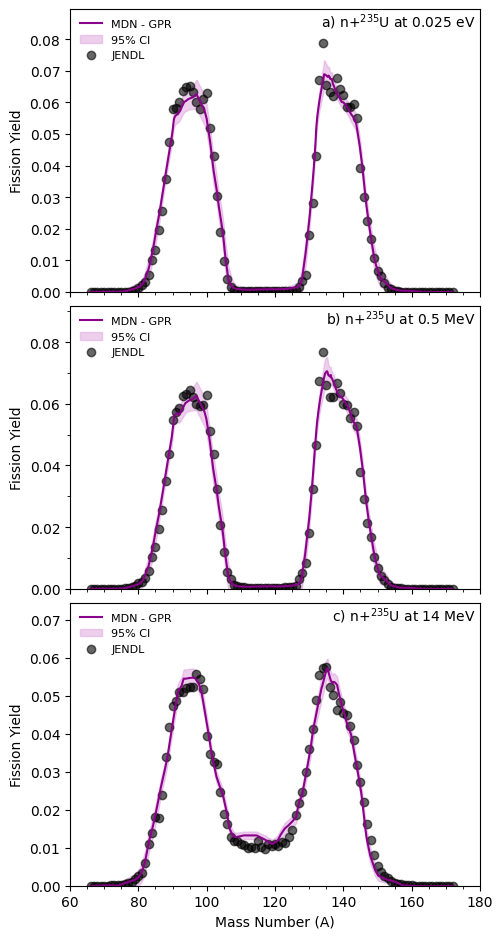

In [533]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

axs[0].plot(X_Pred_Dat_Enh11[:, 0], y_mean11, color='darkmagenta', label='MDN - GPR')
axs[0].fill_between(X_Pred_Dat_Enh11[:, 0], y_mean11[:, 0] - sigma11[:, 0] * 1.96,
                       y_mean11[:, 0] + 1.96 * sigma11[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[0].scatter(X_Pred_Dat11[:, 0], y_Pred_Dat11, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[0].set_ylim(0, y_mean11[:, 0].max() + 0.3 * y_mean11[:, 0].max())
#axs[0, 0].set_xlabel("Mass Number (A)")
axs[0].set_ylabel("Fission Yield")
#axs[0].set_title(r'a) n+$^{235}$U at 0.025 eV')
axs[0].text(0.99, 0.99,r'a) n+$^{235}$U at 0.025 eV', horizontalalignment='right', verticalalignment='top', transform=axs[0].transAxes, fontsize=10)

axs[0].legend(fontsize=8, loc='upper left', facecolor='none',edgecolor='none')

# Second subplot
axs[1].plot(X_Pred_Dat_Enh12[:, 0], y_mean12, color='darkmagenta', label='MDN - GPR')
axs[1].fill_between(X_Pred_Dat_Enh12[:, 0], y_mean12[:, 0] - sigma12[:, 0] * 1.96,
                       y_mean12[:, 0] + 1.96 * sigma12[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[1].scatter(X_Pred_Dat12[:, 0], y_Pred_Dat12, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[1].set_ylim(0, y_mean12[:, 0].max() + 0.3 * y_mean12[:, 0].max())
#axs[0, 1].set_xlabel("Mass Number (A)")
axs[1].set_ylabel("Fission Yield")
#axs[1].set_title(r'b) n+$^{235}$U at 0.5 MeV')
axs[1].text(0.99, 0.99,r'b) n+$^{235}$U at 0.5 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[1].transAxes, fontsize=10)

axs[1].legend(fontsize=8, loc='upper left', facecolor='none',edgecolor='none')

# Third subplot
axs[2].plot(X_Pred_Dat_Enh13[:, 0], y_mean13, color='darkmagenta', label='MDN - GPR')
axs[2].fill_between(X_Pred_Dat_Enh13[:, 0], y_mean13[:, 0] - sigma13[:, 0] * 1.96,
                       y_mean13[:, 0] + 1.96 * sigma13[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[2].scatter(X_Pred_Dat13[:, 0], y_Pred_Dat13, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[2].set_ylim(0, y_mean13[:, 0].max() + 0.3 * y_mean13[:, 0].max())
axs[2].set_xlabel("Mass Number (A)")
axs[2].set_ylabel("Fission Yield")
#axs[2].set_title(r'c) n+$^{235}$U at 14 MeV')
axs[2].text(0.99, 0.99,r'c) n+$^{235}$U at 14 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[2].transAxes, fontsize=10)

axs[2].legend(fontsize=8, loc='upper left', facecolor='none',edgecolor='none')

plt.tight_layout(rect=[0, 0, 1, 0.95])
axs[1].set_xticks(np.arange(60, 181, 20))
axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
fig.subplots_adjust(hspace=0.05, wspace=0.1)
plt.savefig('U_235.png',dpi=300)
plt.show()

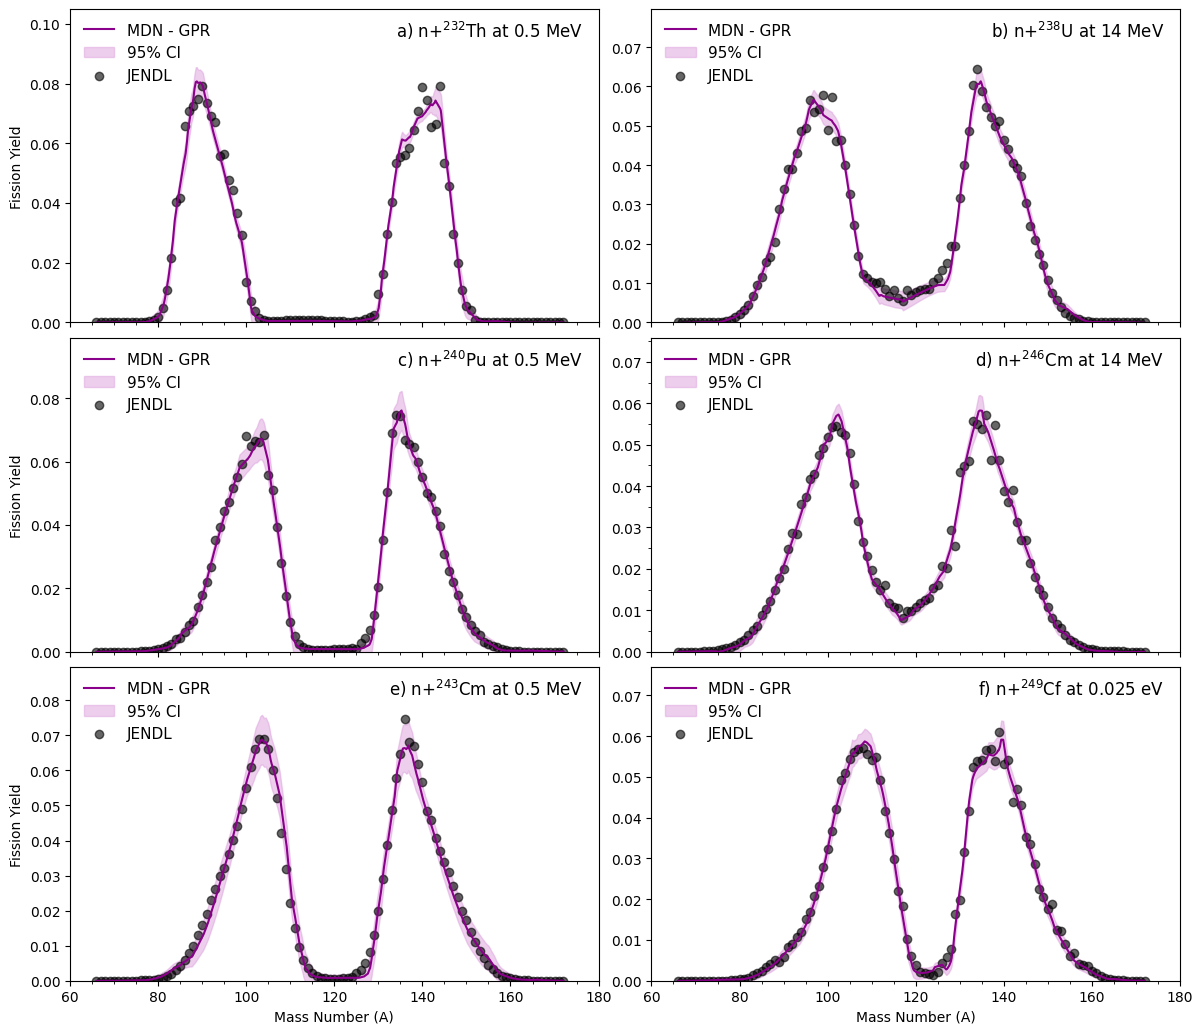

In [534]:
fig, axs = plt.subplots(3, 2, figsize=(12, 11), sharex=True)
#fig.suptitle(r'n+$^{235}U$ at 0.025 eV', fontsize=16)

# First subplot
axs[0, 0].plot(X_Pred_Dat_Enh1[:, 0], y_mean1, color='darkmagenta', label='MDN - GPR')
axs[0, 0].fill_between(X_Pred_Dat_Enh1[:, 0], y_mean1[:, 0] - sigma1[:, 0] * 1.96,
                       y_mean1[:, 0] + 1.96 * sigma1[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[0, 0].scatter(X_Pred_Dat1[:, 0], y_Pred_Dat1, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[0, 0].set_ylim(0, y_mean1[:, 0].max() + 0.3 * y_mean1[:, 0].max())
#axs[0, 0].set_xlabel("Mass Number (A)")
axs[0, 0].set_ylabel("Fission Yield")
#axs[0, 0].set_title(r'a) n+$^{232}$Th at 0.5 MeV')
axs[0, 0].text(0.97, 0.97,r'a) n+$^{232}$Th at 0.5 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes, fontsize=12)
axs[0, 0].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Second subplot
axs[0, 1].plot(X_Pred_Dat_Enh2[:, 0], y_mean2, color='darkmagenta', label='MDN - GPR')
axs[0, 1].fill_between(X_Pred_Dat_Enh2[:, 0], y_mean2[:, 0] - sigma2[:, 0] * 1.96,
                       y_mean2[:, 0] + 1.96 * sigma2[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[0, 1].scatter(X_Pred_Dat2[:, 0], y_Pred_Dat2, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[0, 1].set_ylim(0, y_mean2[:, 0].max() + 0.3 * y_mean2[:, 0].max())
#axs[0, 1].set_xlabel("Mass Number (A)")
#axs[0, 1].set_ylabel("Fission Yield")
#axs[0, 1].set_title(r'b) n+$^{238}$U at 14 MeV')
axs[0, 1].text(0.97, 0.97,r'b) n+$^{238}$U at 14 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes, fontsize=12)
axs[0, 1].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Third subplot
axs[1, 0].plot(X_Pred_Dat_Enh3[:, 0], y_mean3, color='darkmagenta', label='MDN - GPR')
axs[1, 0].fill_between(X_Pred_Dat_Enh3[:, 0], y_mean3[:, 0] - sigma3[:, 0] * 1.96,
                       y_mean3[:, 0] + 1.96 * sigma3[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[1, 0].scatter(X_Pred_Dat3[:, 0], y_Pred_Dat3, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[1, 0].set_ylim(0, y_mean3[:, 0].max() + 0.3 * y_mean3[:, 0].max())
#axs[1, 0].set_xlabel("Mass Number (A)")
axs[1, 0].set_ylabel("Fission Yield")
#axs[1, 0].set_title(r'c) n+$^{240}$Pu at 0.5 MeV')
axs[1, 0].text(0.97, 0.97,r'c) n+$^{240}$Pu at 0.5 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes, fontsize=12)
axs[1, 0].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Fourth subplot
axs[1, 1].plot(X_Pred_Dat_Enh4[:, 0], y_mean4, color='darkmagenta', label='MDN - GPR')
axs[1, 1].fill_between(X_Pred_Dat_Enh4[:, 0], y_mean4[:, 0] - sigma4[:, 0] * 1.96,
                       y_mean4[:, 0] + 1.96 * sigma4[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[1, 1].scatter(X_Pred_Dat4[:, 0], y_Pred_Dat4, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[1, 1].set_ylim(0, y_mean4[:, 0].max() + 0.3 * y_mean4[:, 0].max())
#axs[1, 1].set_xlabel("Mass Number (A)")
#axs[1, 1].set_ylabel("Fission Yield")
#axs[1, 1].set_title(r'd) n+$^{246}$Cm at 14 MeV')
axs[1, 1].text(0.97, 0.97,r'd) n+$^{246}$Cm at 14 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes, fontsize=12)
axs[1, 1].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Fifth subplot
axs[2, 0].plot(X_Pred_Dat_Enh5[:, 0], y_mean5, color='darkmagenta', label='MDN - GPR')
axs[2, 0].fill_between(X_Pred_Dat_Enh5[:, 0], y_mean5[:, 0] - sigma5[:, 0] * 1.96,
                       y_mean5[:, 0] + 1.96 * sigma5[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[2, 0].scatter(X_Pred_Dat5[:, 0], y_Pred_Dat5, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[2, 0].set_ylim(0, y_mean5[:, 0].max() + 0.3 * y_mean5[:, 0].max())
axs[2, 0].set_xlabel("Mass Number (A)")
axs[2, 0].set_ylabel("Fission Yield")
#axs[2, 0].set_title(r'e) n+$^{243}$Cm at 0.5 MeV')
axs[2, 0].text(0.97, 0.97,r'e) n+$^{243}$Cm at 0.5 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[2,0].transAxes, fontsize=12)
axs[2, 0].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Sixth subplot
axs[2, 1].plot(X_Pred_Dat_Enh6[:, 0], y_mean6, color='darkmagenta', label='MDN - GPR')
axs[2, 1].fill_between(X_Pred_Dat_Enh6[:, 0], y_mean6[:, 0] - sigma6[:, 0] * 1.96,
                       y_mean6[:, 0] + 1.96 * sigma6[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[2, 1].scatter(X_Pred_Dat6[:, 0], y_Pred_Dat6, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[2, 1].set_ylim(0, y_mean6[:, 0].max() + 0.3 * y_mean6[:, 0].max())
axs[2, 1].set_xlabel("Mass Number (A)")
#axs[2, 1].set_ylabel("Fission Yield")
#axs[2, 1].set_title(r'f) n+$^{249}$Cf at 0.025 eV')
axs[2, 1].text(0.97, 0.97,r'f) n+$^{249}$Cf at 0.025 eV', horizontalalignment='right', verticalalignment='top', transform=axs[2,1].transAxes, fontsize=12)
axs[2, 1].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
axs[1, 1].set_xticks(np.arange(60, 181, 20))
axs[1, 1].xaxis.set_minor_locator(MultipleLocator(5))
axs[1, 1].yaxis.set_minor_locator(AutoMinorLocator(2))
fig.subplots_adjust(hspace=0.05, wspace=0.1)
plt.savefig('6_learning_set.png',dpi=300)
plt.show()

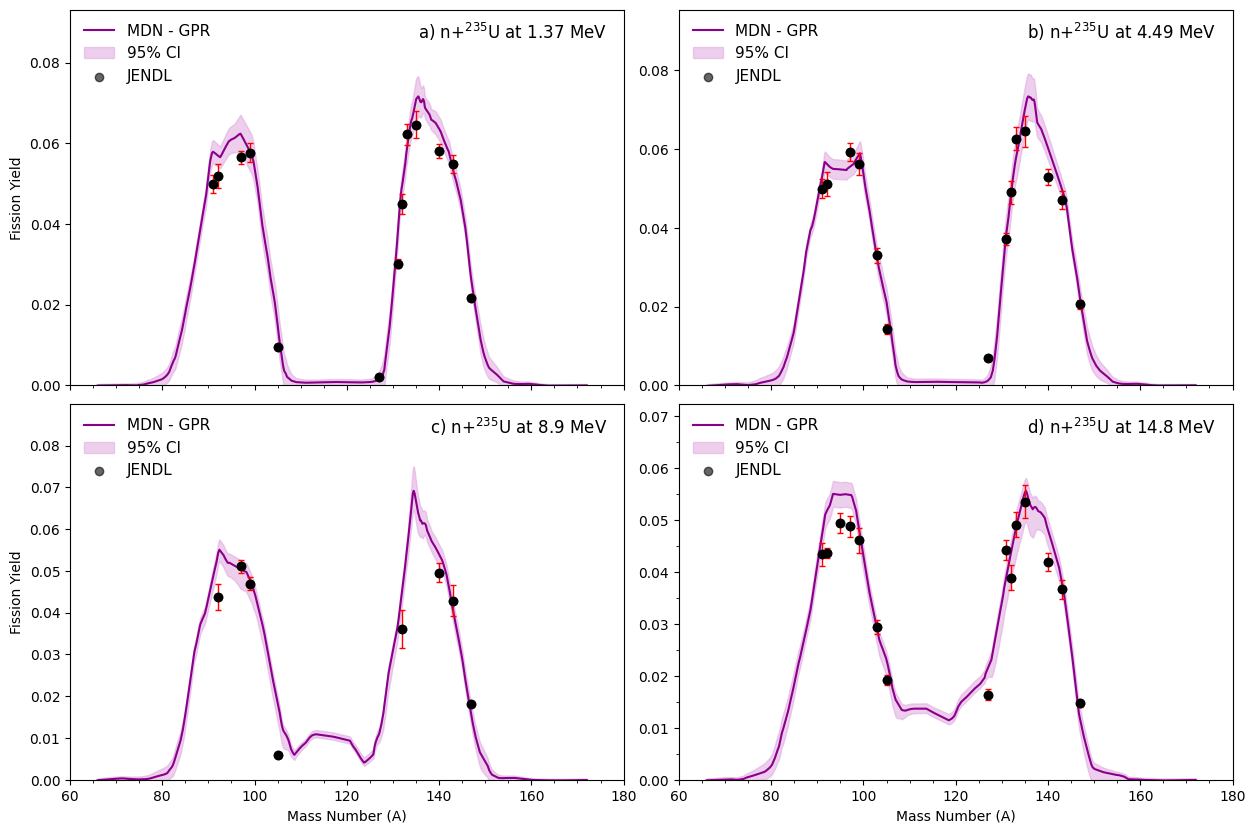

In [535]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
#fig.suptitle(r'n+$^{235}U$ at 0.025 eV', fontsize=16)
#print(X_Pred_Dat_Enh7)
# First subplot
axs[0, 0].plot(X_Pred_Dat_Enh7[:,0], y_mean7, color='darkmagenta', label='MDN - GPR')
axs[0, 0].fill_between(X_Pred_Dat_Enh7[:,0], y_mean7[:, 0] - sigma7[:, 0] * 1.96,
                       y_mean7[:, 0] + 1.96 * sigma7[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[0, 0].scatter(X_Pred_Dat7, y_Pred_Dat7, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[0, 0].errorbar(X_Pred_Dat7, y_Pred_Dat7, yerr=y_error7, fmt='o', ecolor='r', capsize=2, elinewidth=1, capthick=1,markerfacecolor='black', markeredgecolor='black')
axs[0, 0].set_ylim(0, y_mean7[:, 0].max() + 0.3 * y_mean7[:, 0].max())
#axs[0, 0].set_xlabel("Mass Number (A)")
axs[0, 0].set_ylabel("Fission Yield")
#axs[0, 0].set_title(r'a) n+$^{235}$U at 1.37 MeV')
axs[0, 0].text(0.97, 0.97,r'a) n+$^{235}$U at 1.37 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes, fontsize=12)

axs[0, 0].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Second subplot
axs[0, 1].plot(X_Pred_Dat_Enh8[:,0], y_mean8, color='darkmagenta', label='MDN - GPR')
axs[0, 1].fill_between(X_Pred_Dat_Enh8[:,0], y_mean8[:, 0] - sigma8[:, 0] * 1.96,
                       y_mean8[:, 0] + 1.96 * sigma8[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[0, 1].scatter(X_Pred_Dat8, y_Pred_Dat8, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[0, 1].errorbar(X_Pred_Dat8, y_Pred_Dat8, yerr=y_error8, fmt='o', ecolor='r', capsize=2, elinewidth=1, capthick=1,markerfacecolor='black', markeredgecolor='black')
axs[0, 1].set_ylim(0, y_mean8[:, 0].max() + 0.3 * y_mean8[:, 0].max())
#axs[0, 1].set_xlabel("Mass Number (A)")
#axs[0, 1].set_ylabel("Fission Yield")
#axs[0, 1].set_title(r'b) n+$^{235}$U at 4.49 MeV')
axs[0, 1].text(0.97, 0.97,r'b) n+$^{235}$U at 4.49 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes, fontsize=12)

axs[0, 1].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

axs[1, 0].plot(X_Pred_Dat_Enh9[:,0], y_mean9, color='darkmagenta', label='MDN - GPR')
axs[1, 0].fill_between(X_Pred_Dat_Enh9[:,0], y_mean9[:, 0] - sigma7[:, 0] * 1.96,
                       y_mean9[:, 0] + 1.96 * sigma9[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[1, 0].scatter(X_Pred_Dat9, y_Pred_Dat9, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[1, 0].errorbar(X_Pred_Dat9, y_Pred_Dat9, yerr=y_error9, fmt='o', ecolor='r', capsize=2, elinewidth=1, capthick=1,markerfacecolor='black', markeredgecolor='black')
axs[1, 0].set_ylim(0, y_mean9[:, 0].max() + 0.3 * y_mean9[:, 0].max())
axs[1, 0].set_xlabel("Mass Number (A)")
axs[1, 0].set_ylabel("Fission Yield")
#axs[1, 0].set_title(r'a) n+$^{235}$U at 8.9 MeV')
axs[1, 0].text(0.97, 0.97,r'c) n+$^{235}$U at 8.9 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes, fontsize=12)
axs[1, 0].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')

# Second subplot
axs[1, 1].plot(X_Pred_Dat_Enh10[:,0], y_mean10, color='darkmagenta', label='MDN - GPR')
axs[1, 1].fill_between(X_Pred_Dat_Enh10[:,0], y_mean10[:, 0] - sigma8[:, 0] * 1.96,
                       y_mean10[:, 0] + 1.96 * sigma10[:, 0], color='plum', alpha=0.5, label='95% CI')
axs[1, 1].scatter(X_Pred_Dat10, y_Pred_Dat10, color='black', edgecolor='black', alpha=0.6, label='JENDL')
axs[1, 1].errorbar(X_Pred_Dat10, y_Pred_Dat10, yerr=y_error10, fmt='o', ecolor='r', capsize=2, elinewidth=1, capthick=1,markerfacecolor='black', markeredgecolor='black')
axs[1, 1].set_ylim(0, y_mean10[:, 0].max() + 0.3 * y_mean10[:, 0].max())
axs[1, 1].set_xlabel("Mass Number (A)")
#axs[0, 1].set_ylabel("Fission Yield")
axs[1, 1].text(0.97, 0.97,r'd) n+$^{235}$U at 14.8 MeV', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes, fontsize=12)
axs[1, 1].legend(fontsize=11, loc='upper left', facecolor='none',edgecolor='none')
axs[1, 1].set_xticks(np.arange(60, 181, 20))
axs[1, 1].xaxis.set_minor_locator(MultipleLocator(5))
axs[1, 1].yaxis.set_minor_locator(AutoMinorLocator(2))
fig.subplots_adjust(hspace=0.05, wspace=0.1)
fig.savefig('Inc_U235.png',dpi=300)


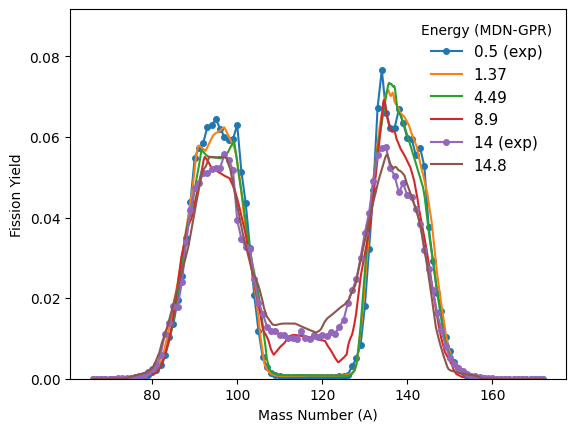

In [536]:
#plt.errorbar(X_Pred_Dat, y_Pred_Dat, yerr=y_error, fmt='o', ecolor='r', capsize=2, elinewidth=1, capthick=1,markerfacecolor='black', markeredgecolor='black')
plt.plot(X_Pred_Dat12[:,0], y_Pred_Dat12, linestyle='-', marker='o', markersize=4, label='0.5 (exp)')
plt.plot(X_Pred_Dat_Enh7[:,0], y_mean7, linestyle='-', label='1.37')
plt.plot(X_Pred_Dat_Enh8[:,0], y_mean8, linestyle='-', label='4.49')
plt.plot(X_Pred_Dat_Enh9[:,0], y_mean9, linestyle='-', label='8.9')
plt.plot(X_Pred_Dat13[:,0], y_Pred_Dat13, linestyle='-', marker='o', markersize=4, label='14 (exp)')
plt.plot(X_Pred_Dat_Enh10[:,0], y_mean10, linestyle='-', label='14.8')
plt.ylim(0, y_mean12[:,0].max()+0.3*y_mean12[:,0].max())
plt.xlabel("Mass Number (A)")
plt.ylabel("Fission Yield")
plt.legend(fontsize=11, title = 'Energy (MDN-GPR)', facecolor='none',edgecolor='none')
plt.savefig('Energies.png',dpi=300)
plt.show()               

In [510]:
def chi_squared(observed, predicted):
    N = len(observed)
    chi2 = np.sum((observed - predicted) ** 2) / N
    return chi21
print("MDN - GMR")
chi2 = chi_squared2(y_mean14, y_Pred_Dat14)
print("Chi^2 of U-235 0.5 MeV prediction:", chi2)
chi25 = chi_squared2(y_mean15, y_Pred_Dat15)
print("Chi^2 of Cm-243 0.5 MeV learning set:", chi25)

MDN - GPR
Chi^2 of U-235 0.5 MeV prediction: 6.572839886586404e-06
Chi^2 of Cm-243 0.5 MeV learning set: 2.0056015961558703e-06
